In [1]:
import arviz as az
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.4.0


In [2]:
# create input data
# xdata/columns: concentrations (uM), ydata/rows: responses
data = {'0.01': [15, 10, 17], '0.1': [22, 16, 20], '1': [45, 39, 47], '10': [95, 92, 97], '100': [100, 105, 98]}

datadf = pd.DataFrame(data)
datadf.head()

,0.01,0.1,1,10,100
0,15,22,45,95,100
1,10,16,39,92,105
2,17,20,47,97,98


In [3]:
# pull data from dataframe, log10 transform concentration data
xdata = [np.log10(float(item[0])) for item in datadf.unstack().index]
print('x data (log concentration):', xdata)
ydata = [item for item in datadf.unstack()]
print('y data (response %):', ydata)

x data (log concentration): [-2.0, -2.0, -2.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0]
y data (response %): [15, 10, 17, 22, 16, 20, 45, 39, 47, 95, 92, 97, 100, 105, 98]


In [4]:
# objective function, logistic model
def objective(x, ec50, b, c, d):
    # ec50: concentration at 50% response
    # b: slope at inflection
    # c: response offset from zero
    # d: response max

    return c + ((d - c) / (1 + np.exp(-b * (x - ec50))))
#    return c + ((d-c) / (1 + np.exp(b * (np.log(ec50) - np.log(x)))))

optimized parameters: [  0.23233662   3.03725244  15.50090878 101.79280135]
residuals: [-0.59883219 -5.59883219  1.40116781  4.50256361 -1.49743639  2.50256361
  0.97466488 -5.02533512  2.97466488  0.84752325 -2.15247675  2.84752325
 -1.39258619  3.60741381 -3.39258619]
mse: 9.16145470921615


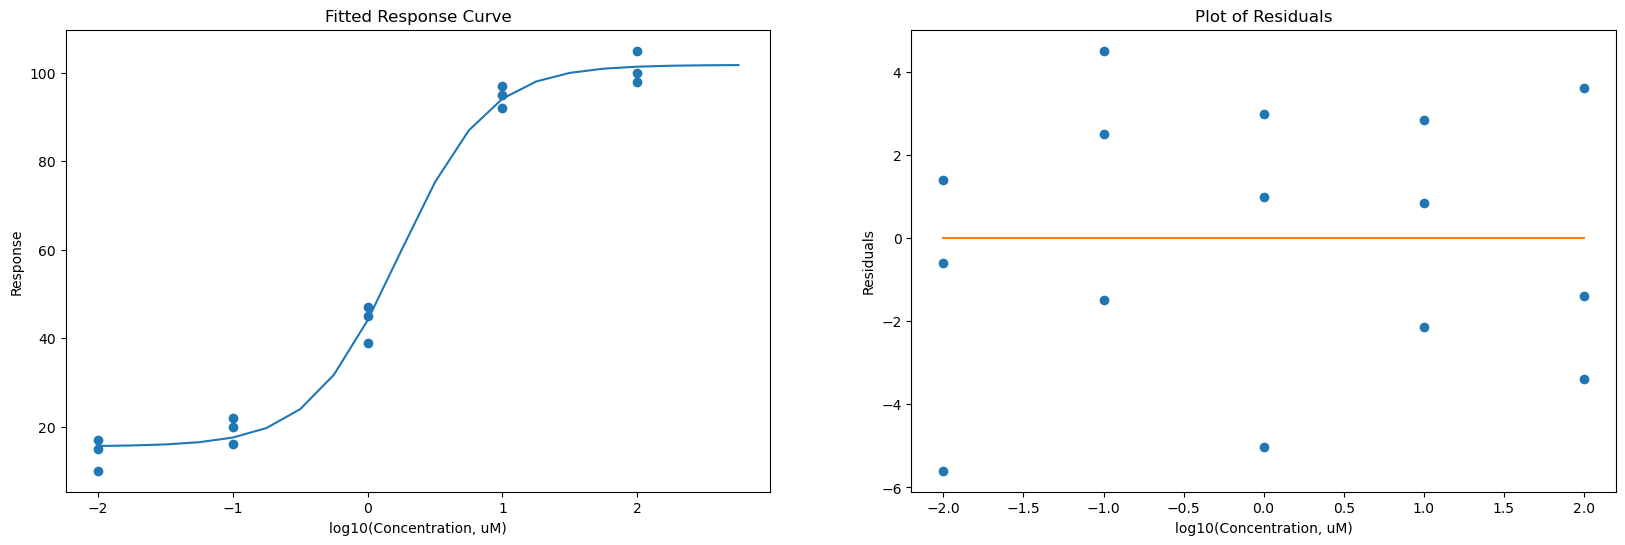

In [5]:
# dose response curve fitting with scipy curve fit

# fit a curve to data, get optimized parameters
popt, cov = curve_fit(objective, xdata, ydata)
print('optimized parameters:', popt)
ec50, b, c, d = popt

# plot data
fig, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].scatter(xdata, ydata)

# plot curve
xs = np.arange(min(xdata), max(xdata) + 1, 0.25)
ys = objective(xs, ec50, b, c, d)
axs[0].plot(xs, ys)
axs[0].set_title('Fitted Response Curve')
axs[0].set_ylabel('Response')
axs[0].set_xlabel('log10(Concentration, uM)')

# plot residuals
predy = objective(xdata, ec50, b, c, d)
residuals = ydata - predy
# axs[0,1].figure()
axs[1].plot(xdata, residuals, 'o')
axs[1].plot(xdata, [0 for i in xdata])
axs[1].set_title('Plot of Residuals')
axs[1].set_ylabel('Residuals')
axs[1].set_xlabel('log10(Concentration, uM)')

# mean square error
mse = np.mean(residuals**2)
print('residuals:', residuals)
print('mse:', mse)

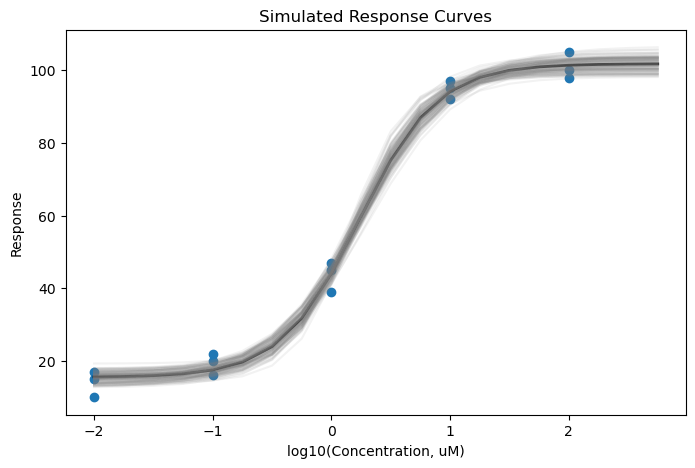

In [6]:
# simulate more data - add noise into measurements

# plot original curve and data
plt.figure(figsize=(8,5))
plt.scatter(xdata, ydata)
xs = np.arange(min(xdata), max(xdata) + 1, 0.25)
ys = objective(xs, ec50, b, c, d)
plt.plot(xs, ys, alpha=1, color='black', linewidth=2)
plt.ylabel('Response')
plt.xlabel('log10(Concentration, uM)')
plt.title('Simulated Response Curves')

ec50s = []
bs = []
cs = []
ds = []
for i in range(100):
    # add some noise to y data, normally distributed around original data
    sim_ydata = []
    for val in ydata:
        sim_ydata.append(val + np.random.normal(loc=0, scale=3))

    # fit curve
    popt, cov = curve_fit(objective, xdata, sim_ydata)
    ec50, b, c, d = popt
    
    # store parameter values
    ec50s.append(ec50)
    bs.append(b)
    cs.append(c)
    ds.append(d)

    xs = np.arange(min(xdata), max(xdata) + 1, 0.25)
    ys = objective(xs, ec50, b, c, d)
    
    plt.plot(xs, ys, alpha=0.1, color='gray')
#     plt.scatter(xdata, sim_ydata)



In [7]:
# summary of simulated data
simdf = pd.DataFrame({'ec50s': ec50s, 'bs': bs, 'cs': cs, 'ds': ds})
simdf.describe()

,ec50s,bs,cs,ds
count,100.000000,100.000000,100.000000,100.000000
mean,0.228674,3.067526,15.365474,101.867751
std,0.036593,0.404087,1.400578,1.901387
min,0.135936,2.278838,12.632389,98.180743
25%,0.203911,2.783004,14.456270,100.369343
50%,0.234771,3.042788,15.415134,101.892939
75%,0.252955,3.282623,16.354149,103.385804
max,0.311889,4.210065,19.265482,106.609259


In [8]:
# pymc

# define model
with pm.Model() as logistic_model:
    # priors for each unknown parameter
    ec50 = pm.Uniform('ec50', lower=min(xdata), upper=max(xdata)) # somewhere between min and max concentration
    b = pm.Normal('b', mu=0, sigma=2) # slope probably around 1
    c = pm.Normal('c', mu=min(ydata), sigma=10) # lower response level around y min
    d = pm.Normal('d', mu=max(ydata), sigma=10) # upper response level around y max
    
    # prior for errors
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # estimated value of output, given by logistic and x data
    est_y = c + ((d - c) / (1 + pm.math.exp(-b * (xdata - ec50))))
#     est_y = pm.Deterministic('est_y', c + ((d - c) / (1 + pm.math.exp(-b * (xdata - ec50)))))
    
    # connect estimated output with observed data
    # observed should be normally distributed around estimated y
    y = pm.Normal('y', mu=est_y, sigma=sigma, observed=ydata)

In [9]:
# draw samples from model
with logistic_model:
    trace = pm.sample(draws=1000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ec50, b, c, d, sigma]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 50 seconds.


array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'ec50'}>,
        <AxesSubplot:title={'center':'ec50'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

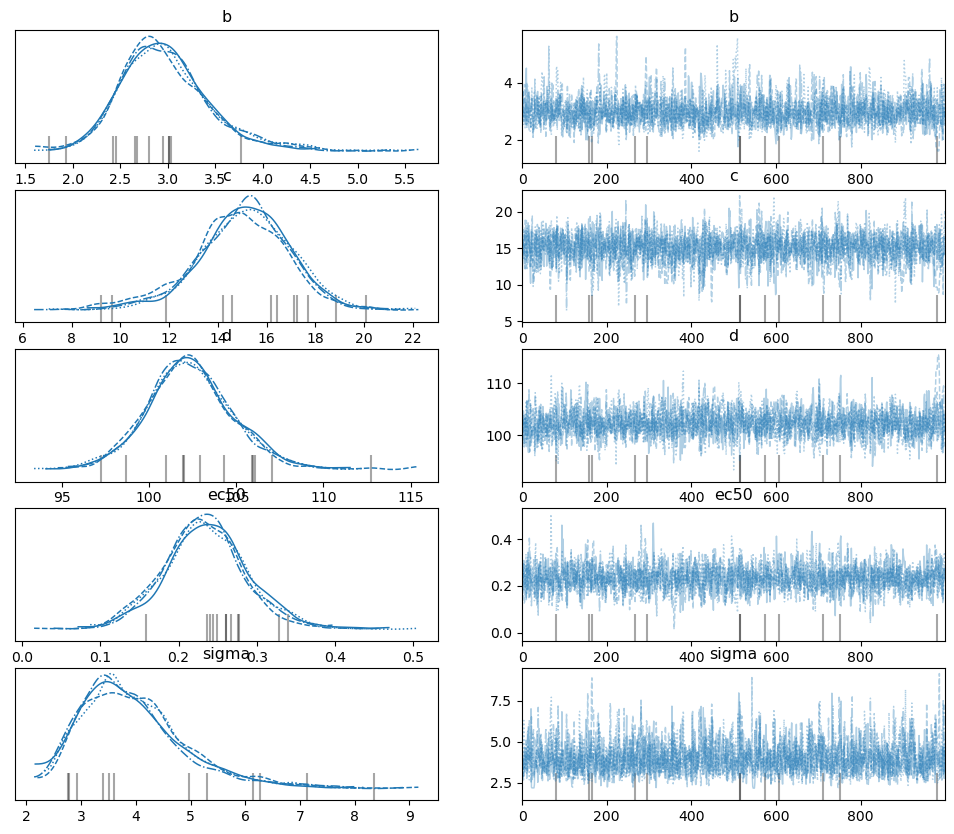

In [10]:
az.plot_trace(trace)

In [11]:
# summary of posterior distributions
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,2.98,0.48,2.13,3.92,0.01,0.01,1590.81,1738.56,1.0
c,15.03,1.94,11.44,18.90,0.05,0.03,1759.06,1464.59,1.0
d,102.37,2.51,97.77,107.15,0.07,0.05,1574.96,1670.14,1.0
ec50,0.23,0.05,0.13,0.33,0.00,0.00,1725.13,2158.02,1.0
sigma,3.95,0.97,2.38,5.78,0.02,0.02,1846.84,1811.72,1.0


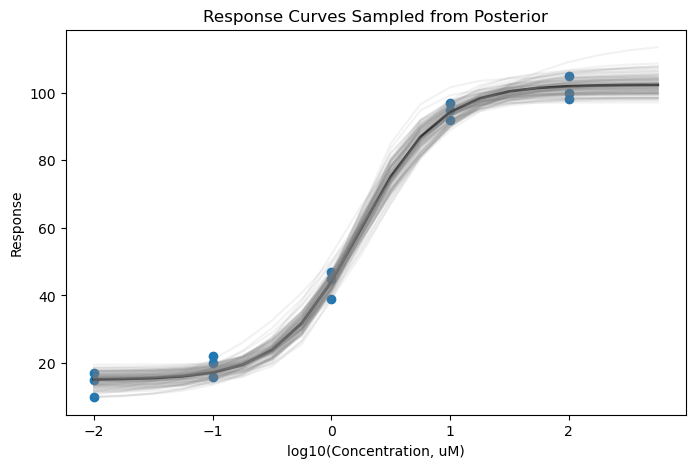

In [12]:
# samples from posteriors
postec50s = trace.posterior['ec50'].values.flatten()
postbs = trace.posterior['b'].values.flatten()
postcs = trace.posterior['c'].values.flatten()
postds = trace.posterior['d'].values.flatten()

# plot original data
plt.figure(figsize=(8,5))
plt.scatter(xdata, ydata)

# plot curve with posterior means of parameters
xs = np.arange(min(xdata), max(xdata) + 1, 0.25)
ys_postmean = objective(xs, postec50s.mean(), postbs.mean(), postcs.mean(), postds.mean())
plt.plot(xs, ys_postmean, alpha=1, color='black', linewidth=2)
plt.ylabel('Response')
plt.xlabel('log10(Concentration, uM)')
plt.title('Response Curves Sampled from Posterior')

# overlay curves using parameter samples from posterior
idxs = np.random.choice(len(postec50s), size=100)
for idx in idxs:
    xs = np.arange(min(xdata), max(xdata) + 1, 0.25)
    ys = objective(xs, postec50s[idx], postbs[idx], postcs[idx], postds[idx])
    plt.plot(xs, ys, alpha=0.1, color='gray')


array([<AxesSubplot:title={'center':'c'}>,
       <AxesSubplot:title={'center':'d'}>,
       <AxesSubplot:title={'center':'ec50'}>], dtype=object)

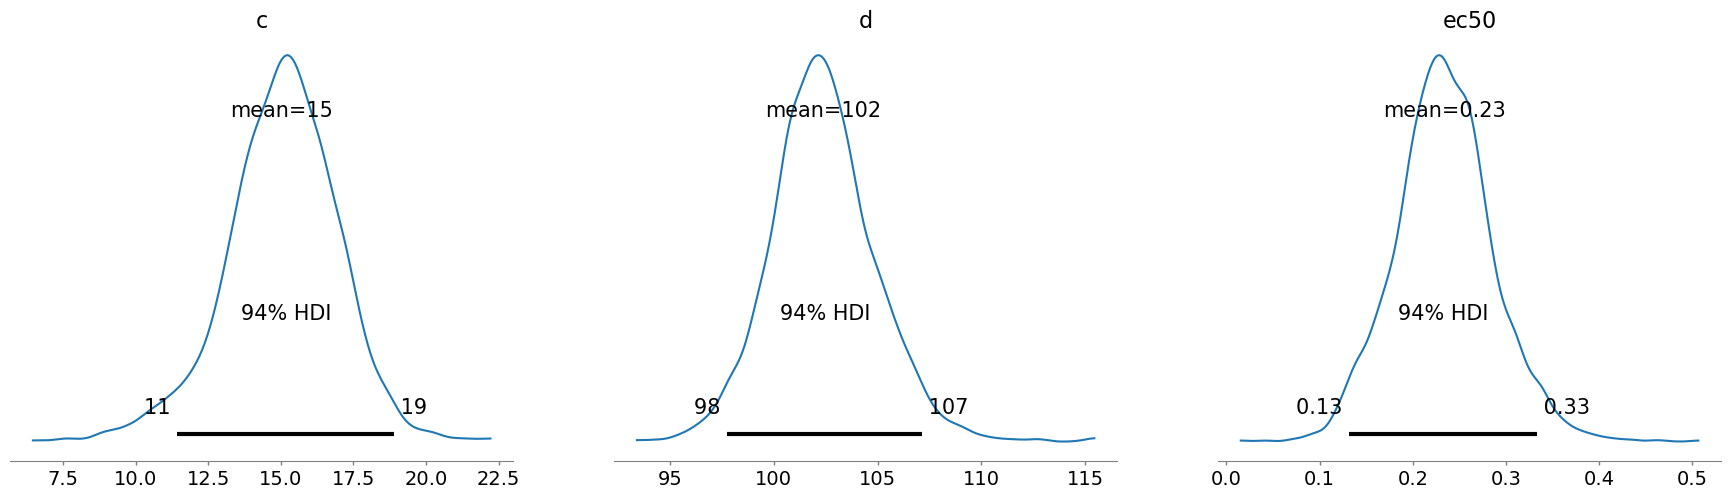

In [13]:
# mean and 94% credible interval 
az.plot_posterior(trace, var_names=['c', 'd', 'ec50'])

<AxesSubplot:>

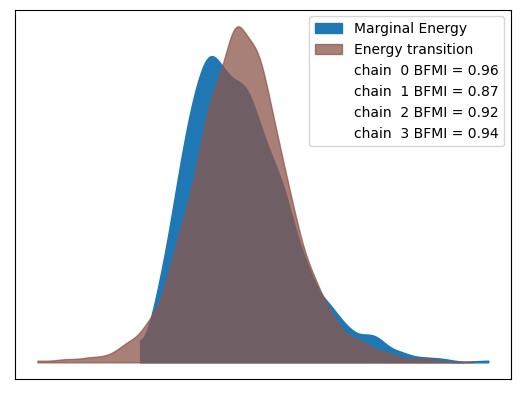

In [14]:
az.plot_energy(trace)